In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from scipy import stats as st
from random import randrange

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.7.0'

In [4]:
pd.options.display.max_rows = 20
pd.options.display.max_columns = 200
data = pd.read_csv('clean_hep.csv', index_col='CASEID')


In [5]:
data = data.drop(['Unnamed: 0'], axis=1)

In [6]:
data.reset_index(inplace=True)
data.drop(['CASEID'], axis=1, inplace=True)

In [7]:
data.shape

(25403, 78)

In [8]:
y = data['HEP_BILELEAKAGE']
X = data.drop(['HEP_BILELEAKAGE'], axis=1)

In [9]:
skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
fold_no=0
for train_index, test_index in skf.split(data, y):
    train = data.loc[train_index,:]
    test = data.loc[test_index,:]
    train_filename = 'train' + str(fold_no) + '.csv'
    test_filename = 'test' + str(fold_no) + '.csv' 
    train.to_csv('splits/' + train_filename, index=False)
    test.to_csv('splits/' + test_filename, index=False) 
    fold_no += 1

In [18]:
d = {}
for x in range(0,5):
    d['train{}'.format(x)] = pd.read_csv('splits/train{}.csv'.format(x), low_memory=False)
    d['test{}'.format(x)] = pd.read_csv('splits/test{}.csv'.format(x), low_memory=False)

In [19]:
for x in range(0,5):
    print(len(d['test1']))

5081
5081
5081
5081
5081


In [20]:
dX_train = []
dy_train = []
for x in d:
    if 'train' in x:
        dX_train.append(d[x].drop(columns=['HEP_BILELEAKAGE'], axis=1))
        dy_train.append(d[x]['HEP_BILELEAKAGE'])

In [21]:
dX_test = []
dy_test = []
for x in d:
    if 'test' in x:
        dX_test.append(d[x].drop(columns=['HEP_BILELEAKAGE'], axis=1))
        dy_test.append(d[x]['HEP_BILELEAKAGE'])

In [22]:
import tensorflow as tf
input_shape = [dX_train[1].shape[1]]
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Flatten(input_shape=input_shape))
model4.add(tf.keras.layers.BatchNormalization())
for _ in range(2):
    model4.add(tf.keras.layers.Dense(1000))
    model4.add(tf.keras.layers.BatchNormalization())
    model4.add(tf.keras.layers.Dropout(0.8))
    model4.add(tf.keras.layers.Activation("relu"))
model4.add(tf.keras.layers.Dense(1, activation="sigmoid"))

opt = tf.keras.optimizers.Adam(learning_rate=3e-5)

metrics = [tf.keras.metrics.Recall(name='Sensitivity'), tf.keras.metrics.TrueNegatives(name='tn'), tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.AUC(name='prc', curve='PR')]

model4.compile(
    optimizer=opt,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=metrics,)

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=25,
    min_delta=1e-6,
    restore_best_weights=True,)


In [23]:
#save untrained model
model4.save('model4.h5')

In [24]:
annpreds = []
for X, y, X_test in zip(dX_train, dy_train, dX_test):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)
    #reset the model with untrained weights
    model4 = tf.keras.models.load_model('model4.h5')
    model4.fit(X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=500,
    callbacks=[early_stopping])
    annpreds.append(model4.predict(X_test))

Epoch 1/500
30/30 [==============================] - 2s 35ms/step - loss: 1.1939 - Sensitivity: 0.5806 - tn: 6442.0000 - auc: 0.5112 - prc: 0.0421 - val_loss: 0.8487 - val_Sensitivity: 0.9439 - val_tn: 260.0000 - val_auc: 0.4667 - val_prc: 0.0353
Epoch 2/500
30/30 [==============================] - 0s 14ms/step - loss: 1.0123 - Sensitivity: 0.4766 - tn: 7632.0000 - auc: 0.4978 - prc: 0.0427 - val_loss: 0.7918 - val_Sensitivity: 0.9133 - val_tn: 605.0000 - val_auc: 0.5122 - val_prc: 0.0396
Epoch 3/500
30/30 [==============================] - 0s 14ms/step - loss: 0.8929 - Sensitivity: 0.4333 - tn: 8546.0000 - auc: 0.5072 - prc: 0.0494 - val_loss: 0.7153 - val_Sensitivity: 0.6837 - val_tn: 1878.0000 - val_auc: 0.5469 - val_prc: 0.0448
Epoch 4/500
30/30 [==============================] - 0s 14ms/step - loss: 0.7706 - Sensitivity: 0.3813 - tn: 9511.0000 - auc: 0.5085 - prc: 0.0465 - val_loss: 0.6370 - val_Sensitivity: 0.2908 - val_tn: 3851.0000 - val_auc: 0.5793 - val_prc: 0.0526
Epoch 5/50

In [25]:
ann_score = []
for x in range(0,5):
    ann_score.append(roc_auc_score(dy_test[x], annpreds[x]))
ann_score

[0.7361053399252054,
 0.7592099293606845,
 0.7332603435582304,
 0.7502934188303323,
 0.7504715375782849]

In [26]:
lrpreds = []
model3 = LogisticRegression(penalty='none', warm_start=False)
for X, y, X_test in zip(dX_train, dy_train, dX_test):
    model3.fit(X, y)
    lrpreds.append(model3.predict_proba(X_test))

C:\Users\KChen\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\KChen\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

In [27]:
lr_score = []
for x in range(0,5):
    lr_score.append(roc_auc_score(dy_test[x], lrpreds[x][:,1]))

In [28]:
lr_score

[0.7133616851674398,
 0.7414817296032156,
 0.7070905558403423,
 0.7230963823870246,
 0.757753201631483]

In [29]:
ann_mean = np.mean(ann_score)
ann_confidence = st.t.interval(0.95, len(ann_score)-1, loc=ann_mean, scale=st.sem(ann_score))

print('Neural Network:', round(ann_mean,3), '('+str(round(ann_confidence[0],3))+'-'+str(round(ann_confidence[1],3))+')')

Neural Network: 0.746 (0.732-0.759)


In [30]:
lr_mean = np.mean(lr_score)
lr_confidence = st.t.interval(0.95, len(lr_score)-1, loc=lr_mean, scale=st.sem(lr_score))

print('Logistic Regression:', round(lr_mean,3), '('+str(round(lr_confidence[0],3))+'-'+str(round(lr_confidence[1],3))+')')

Logistic Regression: 0.729 (0.703-0.754)


In [31]:
ann_prc = []
for x in range(0,5):
    ann_prc.append(average_precision_score(dy_test[x], annpreds[x]))

ann_prc_mean = np.mean(ann_prc)
ann_prc_confidence = st.t.interval(0.95, len(ann_prc)-1, loc=ann_prc_mean, scale=st.sem(ann_prc))

print('Neural Network:', round(ann_prc_mean,3), '('+str(round(ann_prc_confidence[0],3))+'-'+str(round(ann_prc_confidence[1],3))+')')

Neural Network: 0.116 (0.104-0.128)


In [32]:
lr_prc = []
for x in range(0,5):
    lr_prc.append(average_precision_score(dy_test[x], lrpreds[x][:,1]))

lr_prc_mean = np.mean(lr_prc)
lr_prc_confidence = st.t.interval(0.95, len(lr_prc)-1, loc=lr_prc_mean, scale=st.sem(lr_prc))

print('Logistic Regression:', round(lr_prc_mean,3), '('+str(round(lr_prc_confidence[0],3))+'-'+str(round(lr_prc_confidence[1],3))+')')

Logistic Regression: 0.115 (0.098-0.132)


In [33]:
with open('hep_results.txt', 'w') as f:
    f.write('Logistic Regression: '+str(round(lr_mean,3))+' ('+str(round(lr_confidence[0],3))+'-'+str(round(lr_confidence[1],3))+')\n')
    f.write('Neural Network: '+str(round(ann_mean,3))+' ('+str(round(ann_confidence[0],3))+'-'+str(round(ann_confidence[1],3))+')\n')
    f.write('AUPRC\n')
    f.write('Logistic Regression: '+str(round(lr_prc_mean,3))+' ('+str(round(lr_prc_confidence[0],3))+'-'+str(round(lr_prc_confidence[1],3))+')\n')
    f.write('Neural Network: '+str(round(ann_prc_mean,3))+' ('+str(round(ann_prc_confidence[0],3))+'-'+str(round(ann_prc_confidence[1],3))+')')

In [34]:
hep_ann_tpr = []
hep_ann_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], annpreds[x], drop_intermediate=False)
    hep_ann_tpr.append(tpr)
    hep_ann_fpr.append(fpr)


In [35]:
for x in range(0,5):
    print(len(hep_ann_tpr[x]))

5081
5080
5080
5079
5080


In [36]:
mean_hep_ann_tpr = [np.mean(k) for k in zip(*hep_ann_tpr)]
mean_hep_ann_fpr = [np.mean(k) for k in zip(*hep_ann_fpr)]
%store mean_hep_ann_tpr
%store mean_hep_ann_fpr


Stored 'mean_hep_ann_tpr' (list)
Stored 'mean_hep_ann_fpr' (list)


In [37]:

hep_lr_tpr = []
hep_lr_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], lrpreds[x][:,1])
    hep_lr_tpr.append(tpr)
    hep_lr_fpr.append(fpr)
for x in range(0,5):
    diff = len(hep_lr_tpr[x]) - 310
    for _ in range(diff):
        ind = randrange(len(hep_lr_tpr[x]))
        hep_lr_tpr[x] = np.delete(hep_lr_tpr[x],ind)

for x in range(0,5):
    diff = len(hep_lr_fpr[x]) - 310
    for _ in range(diff):
        ind = randrange(len(hep_lr_fpr[x]))
        hep_lr_fpr[x] = np.delete(hep_lr_fpr[x],ind)


mean_hep_lr_tpr = [np.mean(k) for k in zip(*hep_lr_tpr)]
mean_hep_lr_fpr = [np.mean(k) for k in zip(*hep_lr_fpr)]
%store mean_hep_lr_tpr
%store mean_hep_lr_fpr


Stored 'mean_hep_lr_tpr' (list)
Stored 'mean_hep_lr_fpr' (list)


In [38]:

hep_lr_rec = []
hep_lr_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], lrpreds[x][:,1])
    hep_lr_rec.append(rec)
    hep_lr_prec.append(prec)


In [39]:
for x in range(0,5):
    print(len(hep_lr_rec[x]))

4829
5073
4815
4987
4988


In [40]:

for x in range(0,5):
    diff = len(hep_lr_rec[x]) - 4800
    for _ in range(diff):
        ind = randrange(len(hep_lr_rec[x]))
        hep_lr_rec[x] = np.delete(hep_lr_rec[x],ind)

for x in range(0,5):
    diff = len(hep_lr_prec[x]) - 4800
    for _ in range(diff):
        ind = randrange(len(hep_lr_prec[x]))
        hep_lr_prec[x] = np.delete(hep_lr_prec[x],ind)

mean_hep_lr_rec = [np.mean(k) for k in zip(*hep_lr_rec)]
mean_hep_lr_prec = [np.mean(k) for k in zip(*hep_lr_prec)]
%store mean_hep_lr_rec
%store mean_hep_lr_prec


Stored 'mean_hep_lr_rec' (list)
Stored 'mean_hep_lr_prec' (list)


In [41]:
from matplotlib import pyplot as plt

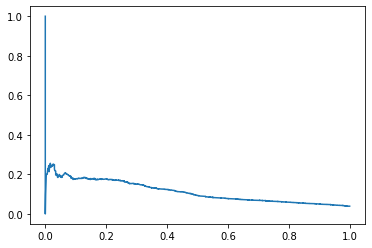

In [42]:
plt.plot(mean_hep_lr_rec, mean_hep_lr_prec)

In [43]:

hep_ann_rec = []
hep_ann_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], annpreds[x])
    hep_ann_rec.append(rec)
    hep_ann_prec.append(prec)

for x in range(0,5):
    diff = len(hep_ann_rec[x]) - 4500
    for _ in range(diff):
        ind = randrange(len(hep_ann_rec[x]))
        hep_ann_rec[x] = np.delete(hep_ann_rec[x],ind)

for x in range(0,5):
    diff = len(hep_ann_prec[x]) - 4500
    for _ in range(diff):
        ind = randrange(len(hep_ann_prec[x]))
        hep_ann_prec[x] = np.delete(hep_ann_prec[x],ind)

mean_hep_ann_rec = [np.mean(k) for k in zip(*hep_ann_rec)]
mean_hep_ann_prec = [np.mean(k) for k in zip(*hep_ann_prec)]
%store mean_hep_ann_rec
%store mean_hep_ann_prec

Stored 'mean_hep_ann_rec' (list)
Stored 'mean_hep_ann_prec' (list)


hep_ann_tpr = []
hep_ann_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], annpreds[x])
    hep_ann_tpr.append(tpr)
    hep_ann_fpr.append(fpr)
hep_ann_tpr_array = [np.array(x) for x in hep_ann_tpr]
mean_hep_ann_tpr = [np.mean(k) for k in zip(*hep_ann_tpr_array)]
hep_ann_fpr_array = [np.array(x) for x in hep_ann_fpr]
mean_hep_ann_fpr = [np.mean(k) for k in zip(*hep_ann_fpr_array)]
%store mean_hep_ann_tpr
%store mean_hep_ann_fpr

hep_lr_tpr = []
hep_lr_fpr = []
for x in range(0,5):
    fpr, tpr, _ = roc_curve(dy_test[x], lrpreds[x][:,1])
    hep_lr_tpr.append(tpr)
    hep_lr_fpr.append(fpr)
hep_lr_tpr_array = [np.array(x) for x in hep_lr_tpr]
mean_hep_lr_tpr = [np.mean(k) for k in zip(*hep_lr_tpr_array)]
hep_lr_fpr_array = [np.array(x) for x in hep_lr_fpr]
mean_hep_lr_fpr = [np.mean(k) for k in zip(*hep_lr_fpr_array)]
%store mean_hep_lr_tpr
%store mean_hep_lr_fpr
hep_ann_rec = []
hep_ann_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], annpreds[x])
    hep_ann_rec.append(rec)
    hep_ann_prec.append(prec)
hep_ann_rec_array = [np.array(x) for x in hep_ann_rec]
mean_hep_ann_rec = [np.mean(k) for k in zip(*hep_ann_rec_array)]
hep_ann_prec_array = [np.array(x) for x in hep_ann_prec]
mean_hep_ann_prec = [np.mean(k) for k in zip(*hep_ann_prec_array)]
%store mean_hep_ann_rec
%store mean_hep_ann_prec

hep_lr_rec = []
hep_lr_prec = []
for x in range(0,5):
    prec, rec, _ = precision_recall_curve(dy_test[x], lrpreds[x][:,1])
    hep_lr_rec.append(rec)
    hep_lr_prec.append(prec)
hep_lr_rec_array = [np.array(x) for x in hep_lr_rec]
mean_hep_lr_rec = [np.mean(k) for k in zip(*hep_lr_rec_array)]
hep_lr_prec_array = [np.array(x) for x in hep_lr_prec]
mean_hep_lr_prec = [np.mean(k) for k in zip(*hep_lr_prec_array)]
%store mean_hep_lr_rec
%store mean_hep_lr_prec


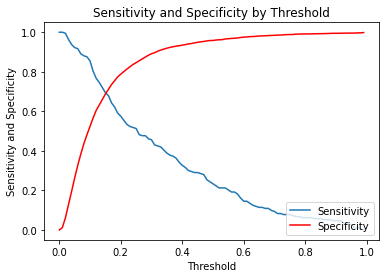

In [46]:
from imblearn.metrics import specificity_score
thresh = np.arange(0, 1, 0.01)
#calculate recall at 10 thresholds
annrecall_list = []
for i in thresh:
    annrecall_list.append(recall_score(dy_test[1], annpreds[1] > i))
#calculate spec at 10 thresholds
annspec_list = []
for i in thresh:
    annspec_list.append(specificity_score(dy_test[1], annpreds[1] > i))
from matplotlib import pyplot as plt
#plot recall vs threshold
plt.plot(thresh, annrecall_list, label = 'Sensitivity')
plt.plot(thresh, annspec_list, color = 'red', label = 'Specificity')
plt.xlabel('Threshold')
plt.ylabel('Sensitivity and Specificity')
plt.title('Sensitivity and Specificity by Threshold')
plt.legend(loc="lower right")
plt.show()
thresh = np.arange(0, 1, 0.01)


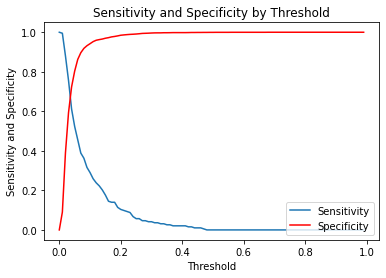

In [47]:
#calculate recall at 10 thresholds
lrrecall_list = []
for i in thresh:
    lrrecall_list.append(recall_score(dy_test[1], lrpreds[1][:,1] > i))
#calculate spec at 10 thresholds
lrspec_list = []
for i in thresh:
    lrspec_list.append(specificity_score(dy_test[1], lrpreds[1][:,1] > i))
from matplotlib import pyplot as plt
#plot recall vs threshold
plt.plot(thresh, lrrecall_list, label = 'Sensitivity')
plt.plot(thresh, lrspec_list, color = 'red', label = 'Specificity')
plt.xlabel('Threshold')
plt.ylabel('Sensitivity and Specificity')
plt.title('Sensitivity and Specificity by Threshold')
plt.legend(loc="lower right")
plt.show()


In [48]:
print(recall_score(dy_test[1], lrpreds[1][:,1] > 0.03))
print(specificity_score(dy_test[1], lrpreds[1][:,1] > 0.03))


0.7564766839378239
0.5928805237315876


In [49]:
print(recall_score(dy_test[1], annpreds[1] > 0.125))
print(specificity_score(dy_test[1], annpreds[1] > 0.125))

0.7512953367875648
0.6180441898527005


In [50]:
from matplotlib import pyplot as plt
import scipy.stats as st
from sklearn import metrics

def auc(X, Y):
    return 1/(len(X)*len(Y)) * sum([kernel(x, y) for x in X for y in Y])
def kernel(X, Y):
    return .5 if Y==X else int(Y < X)
def structural_components(X, Y):
    V10 = [1/len(Y) * sum([kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([kernel(x, y) for x in X]) for y in Y]
    return V10, V01
    

def get_S_entry(V_A, V_B, auc_A, auc_B):
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])
def z_score(var_A, var_B, covar_AB, auc_A, auc_B):
    return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))


p = []
z = []

for x in range(0,5):
    preds_A = annpreds[x]
    preds_B = lrpreds[x][:,1]
    actual = dy_test[x]

    actual = actual.array

    def group_preds_by_label(preds, actual):
        X = [p for (p, a) in zip(preds, actual) if a]
        Y = [p for (p, a) in zip(preds, actual) if not a]
        return X, Y


    X_A, Y_A = group_preds_by_label(preds_A, actual)
    X_B, Y_B = group_preds_by_label(preds_B, actual)
    V_A10, V_A01 = structural_components(X_A, Y_A)
    V_B10, V_B01 = structural_components(X_B, Y_B)
    auc_A = auc(X_A, Y_A)
    auc_B = auc(X_B, Y_B)


    # Compute entries of covariance matrix S (covar_AB = covar_BA)
    var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
            + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
    var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
            + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
    covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

    # Two tailed test
    z.append(z_score(var_A, var_B, covar_AB, auc_A, auc_B))
    p.append(st.norm.sf(abs(z[x-1]))*2)


In [51]:
p

[0.02878554973814149,
 0.02878554973814149,
 0.041249800102458614,
 0.025162249891738275,
 0.005967036174264849]

In [52]:
sum(p)/(len(p))

0.025990037128948946